<a href="https://colab.research.google.com/github/Alex-Chen1121/Deep-Leaning/blob/main/Anomaly_Detection_ECG_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm

In [2]:
# Download the dataset
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',
                 header=None)
raw_data = df.values
df.iloc[:, -1] = 1-df.iloc[:, -1]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,0.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,0.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,0.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,0.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,0.0


In [3]:
print(df.iloc[:, -1].value_counts())

0.0    2919
1.0    2079
Name: 140, dtype: int64


In [4]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, :-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=5566
)

In [5]:
train_data.shape, test_data.shape

((3998, 140), (1000, 140))

In [6]:
labels

array([0., 0., 0., ..., 1., 1., 1.])

In [7]:
# Normalization : 0~1
min_val = train_data.min()
max_val = train_data.max()

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

In [8]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomaly_train_data = train_data[train_labels]
anomaly_test_data = test_data[test_labels]

In [9]:
anomaly_train_data.shape, anomaly_test_data.shape

((1643, 140), (436, 140))

In [10]:
normal_train_data.shape, normal_test_data.shape

((2355, 140), (564, 140))

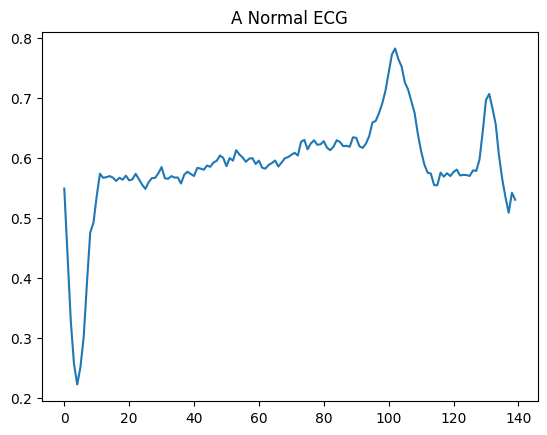

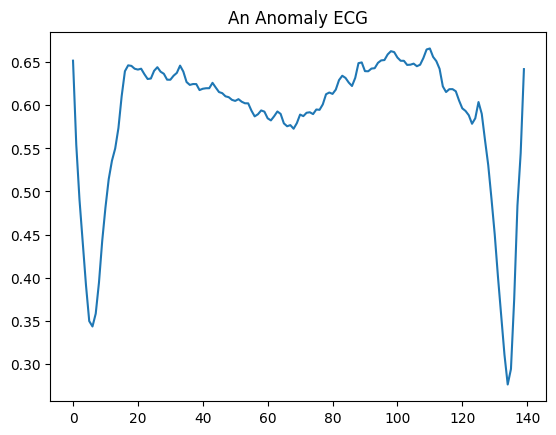

In [11]:
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()
plt.plot(np.arange(140), anomaly_train_data[0])
plt.title("An Anomaly ECG")
plt.show()

In [12]:
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        data = torch.tensor(data, dtype=torch.float)
        return data

train_ds = ECGDataset(normal_train_data)
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=128,
                                           shuffle=True)

#### Build Model

In [13]:
class AnomalyDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(140, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 140),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [14]:
model = AnomalyDetector()

In [15]:
# mock data
inputs = torch.randn(1, 140)
outputs = model(inputs)
outputs.shape

torch.Size([1, 140])

#### Training

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [17]:
def train_epoch(model, dataloader, loss_fn, opt):
    total_loss = 0
    for x in dataloader:
        # 過去的梯度歸零
        opt.zero_grad()
        x = x.to(device)
        pred = model(x)
        loss = loss_fn(pred, x)

        loss.backward()
        opt.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

In [18]:
opt = torch.optim.Adam(model.parameters())
# MAE loss
# 訊號是時間序列 用回歸的方式
# torch.nn.MSELoss()
loss_fn = torch.nn.L1Loss()

for i in range(20):
    loss = train_epoch(model, train_loader, loss_fn, opt)
    print(f'EPOCH {i:04d}: {loss:.4f}')

EPOCH 0000: 0.0982
EPOCH 0001: 0.0696
EPOCH 0002: 0.0424
EPOCH 0003: 0.0301
EPOCH 0004: 0.0254
EPOCH 0005: 0.0238
EPOCH 0006: 0.0233
EPOCH 0007: 0.0231
EPOCH 0008: 0.0231
EPOCH 0009: 0.0231
EPOCH 0010: 0.0231
EPOCH 0011: 0.0231
EPOCH 0012: 0.0231
EPOCH 0013: 0.0232
EPOCH 0014: 0.0231
EPOCH 0015: 0.0232
EPOCH 0016: 0.0231
EPOCH 0017: 0.0232
EPOCH 0018: 0.0230
EPOCH 0019: 0.0232


#### Inference (Reconsturction) 重建

In [19]:
normal_test_ds = ECGDataset(normal_test_data)
normal_test_loader = torch.utils.data.DataLoader(normal_test_ds,
                                                 batch_size=512)

anomaly_test_ds = ECGDataset(anomaly_test_data)
anomaly_test_loader = torch.utils.data.DataLoader(anomaly_test_ds,
                                                  batch_size=512)

model = model.eval()

In [20]:
def inference(model, loader):
    outputs = []
    with torch.no_grad():
        for x in loader:
            x = x.to(device)
            pred = model(x)
            outputs.append(pred)
    return torch.cat(outputs, dim=0).cpu().numpy()

def plot_error(original, reconstruct):
    idx = 1
    plt.plot(original, 'b')
    plt.plot(reconstruct, 'r')
    plt.fill_between(np.arange(140),
                     reconstruct,
                     original,
                     color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()
    print("Mean Avg Error", np.mean(np.abs(original - reconstruct)))

In [21]:
# Normal
normal_test_reconstruct = inference(model, normal_test_loader)
anomaly_test_reconstruct = inference(model, anomaly_test_loader)
normal_test_reconstruct.shape, anomaly_test_reconstruct.shape

((564, 140), (436, 140))

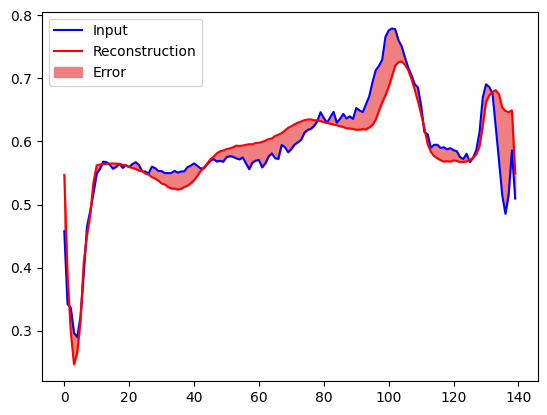

Mean Avg Error 0.025573426990189465


In [22]:
idx = 1
plot_error(normal_test_data[idx], normal_test_reconstruct[idx])

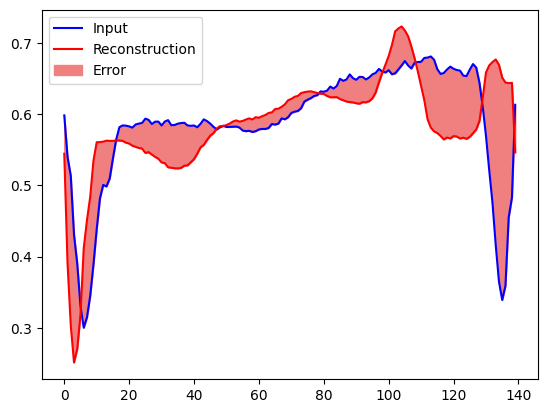

Mean Avg Error 0.05615806859537057


In [23]:
# Abnormal
idx = 1
plot_error(anomaly_test_data[idx], anomaly_test_reconstruct[idx])

In [24]:
normal_train_reconstruct = inference(model, train_loader)

In [25]:
train_loss = np.mean(np.abs(normal_train_reconstruct - normal_train_data),
                     axis=1)

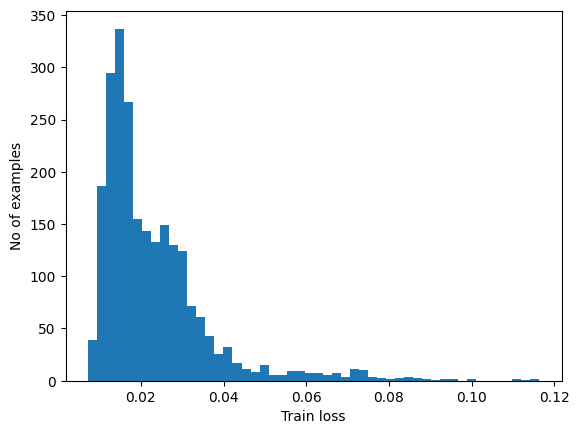

In [26]:
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [27]:
thresholds = [np.mean(train_loss) + np.std(train_loss)*i for i in range(4)]
print(f"Thresholds: {thresholds}")

Thresholds: [0.02325422289241416, 0.03734045162105734, 0.05142668034970052, 0.0655129090783437]


#### Evaluation

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

test_ds = ECGDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64)

def evaluation(model, dataloader, threshold, labels):

    input_data = []
    reconstruct = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            pred = model(data)
            input_data.append(data)
            reconstruct.append(pred)

    input_data = torch.cat(input_data, dim=0).cpu().numpy()
    reconstruct = torch.cat(reconstruct, dim=0).cpu().numpy()

    reconstruct_losses = np.mean(np.abs(reconstruct - input_data),
                                 axis=1)
    # loss > threshold:  1
    # loss <= threshold: 0
    reconstruct_classification = np.where(reconstruct_losses > threshold, 1, 0)

    print(f"Threshold = {threshold:.3f}")
    print(f"Accuracy  = {accuracy_score(labels, reconstruct_classification):.3f}".format())
    print(f"Precision = {precision_score(labels, reconstruct_classification):.3f}")
    print(f"Recall    = {recall_score(labels, reconstruct_classification):.3f} \n ===")

In [29]:
# Evaluation on different threshold
for i, threshold in enumerate(thresholds):
    print(f"thrshold = mean + {i}*std")
    evaluation(model, test_loader, threshold, test_labels)

thrshold = mean + 0*std
Threshold = 0.023
Accuracy  = 0.772
Precision = 0.657
Recall    = 0.998 
 ===
thrshold = mean + 1*std
Threshold = 0.037
Accuracy  = 0.941
Precision = 0.890
Recall    = 0.986 
 ===
thrshold = mean + 2*std
Threshold = 0.051
Accuracy  = 0.890
Precision = 0.922
Recall    = 0.817 
 ===
thrshold = mean + 3*std
Threshold = 0.066
Accuracy  = 0.622
Precision = 0.822
Recall    = 0.170 
 ===
